# SSD - Single Shot Detector for Object Detection

Object detection is a computer vision task aimed at identifying and locating multiple objects within an image or a video frame.

This task combines two key challenges:

* **Classification**: This involves determining the type or category of objects present in the image, similar to a standard classification problem.

* **Localization**: This is a regression problem, where the goal is to find the exact location of each detected object within the image, typically by providing coordinates for a bounding box around each object.

The Single Shot Detector (SSD) is a popular and effective framework for designing networks architectures that can solve object detection tasks.

In this notebook, we'll quickly have a look at the core ideas behind SSD and see how it helps solve this challenging task.

## Dependecies and Parameters

Let's quickly import dependecies and define some useful parameters for this notebook.

In [2]:
# dependecies
import json
import csv
import random
import numpy as np
from matplotlib import pyplot as plt, colors as pltcolors, patches
from PIL import Image
import ssdseglib

# input image shape
INPUT_IMAGE_SHAPE = (480, 640)

# labels conversions
LABEL_CODE_TO_DESC = {
    1: 'monorail',
    2: 'person',
    3: 'forklift'
}

LABEL_CODE_TO_COLOR = {
    1: 'red',
    2: 'green',
    3: 'blue'
}

## Ground Truth Data

Let's take a look at some ground truth examples for our object detection task. 

Ground truth data includes images with labeled bounding boxes that indicate where each object is located. In our case, we're focusing on three specific classes: **monorails**, **forks**, and **persons**.

The code in the cell below loads a few sample images along with their associated metadata, which contains information about the objects in each image and their bounding boxes. We'll then plot these images, displaying the bounding boxes around the objects to visually verify that our labels are correct.


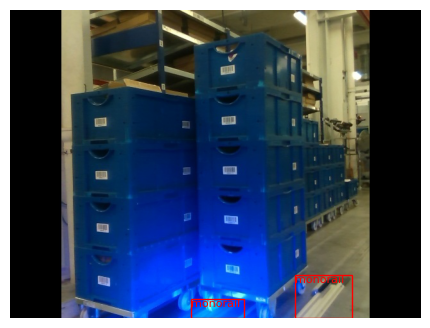

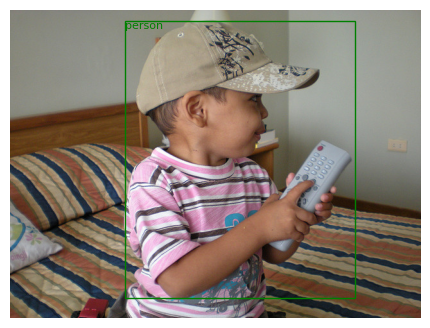

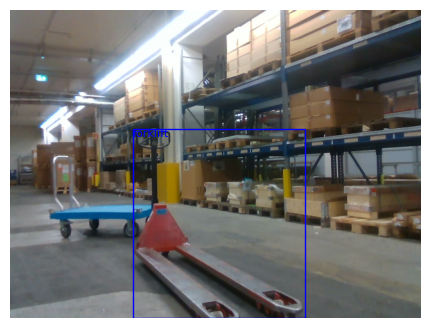

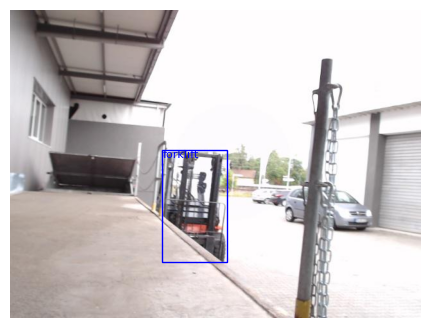

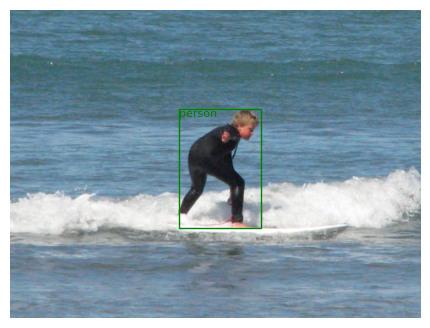

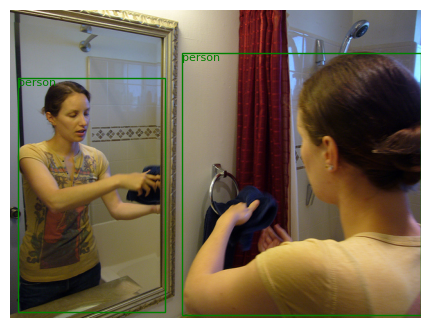

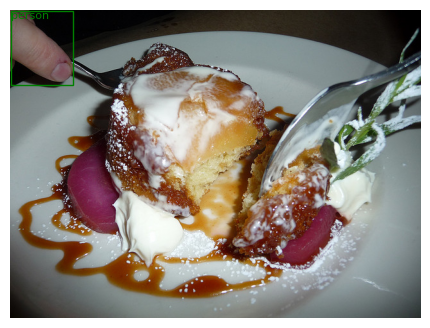

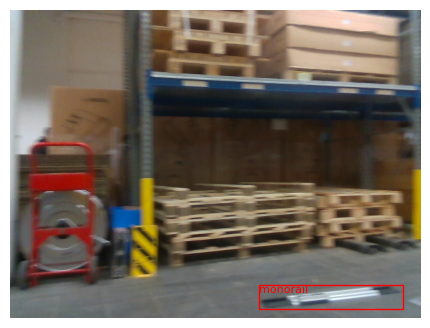

In [7]:
# load some sample metadata
data = []

with open('data/train.json', 'r') as f:
    data.extend(json.load(f))

with open('data/train-additional-persons.json', 'r') as f:
    persons = json.load(f)
    persons = random.sample(persons, int(len(persons)*0.8))
    data.extend(persons)

with open('data/train-additional-forklifts.json', 'r') as f:
    data.extend(json.load(f))

with open('data/eval-persons-forklifts.json', 'r') as f:
    data.extend(json.load(f))

# unpack train metadata into separate lists
path_files_images_train, path_files_masks_train, path_files_labels_boxes_train = map(list, zip(*data))

# plot some random samples
for path_file_image, path_file_mask, path_files_labels_boxes in random.sample(data, 8):

    # read labels and boxes
    with open(path_files_labels_boxes, 'r') as f:
        labels_boxes = list(csv.reader(f))
    
    # read image
    image = Image.open(path_file_image)
    image = np.array(image)
    image = image.astype(np.int32)

    # create the plot
    fig = plt.figure(figsize=(6, 4))

    # plot the image
    plt.imshow(image, vmin=0, vmax=255)
    plt.axis('off')

    # get the current plot object
    ax = plt.gca()

    # plot bounding boxes
    for label, xmin, ymin, xmax, ymax in labels_boxes:
        # type conversions
        label = int(label)
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)

        # bounding boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
        ax.add_patch(rect)

        # label descriptions
        plt.text(xmin, ymin, LABEL_CODE_TO_DESC[label], fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')

    # show the plot
    plt.show()

## SSD - Single Shot Multibox Detector

In the field of computer vision, object detection poses a significant challenge with several effective methods available. One of the most efficient approaches is the Single Shot Multibox Detector (SSD).

SSD is designed to quickly detect objects by predicting both their classes and bounding box locations in a single pass through the network. This makes it well-suited for real-time applications.

The core idea behind SSD is to place a grid of points on the image. At each of these points, a set of default boxes with various aspect ratios and sizes is generated. These default boxes are used to cover different potential object locations.

The network architecture is designed so that some of its feature maps align with the size of the default grids. The subsequent layers then perform two tasks: predicting the offsets needed to adjust the default boxes to fit the detected objects (regression) and determining the probability that each box contains a specific object class (classification).

### Default Grids

A key feature of the SSD framework is the use of multiple grids of points. But why use multiple grids instead of just one?

Each point in these grids serves as a potential location for detecting objects. By employing grids of different densities, SSD can effectively detect objects at various scales and positions within the image. More sparse grids are better for detecting larger objects, while more dense grids are more effective for capturing finer details. This combination allows SSD to handle a wide range of object sizes in a single pass.

Below is a code snippet that demonstrates how these grids are created and visualized. Each point on the grid represents a location where default boxes are used to detect objects.


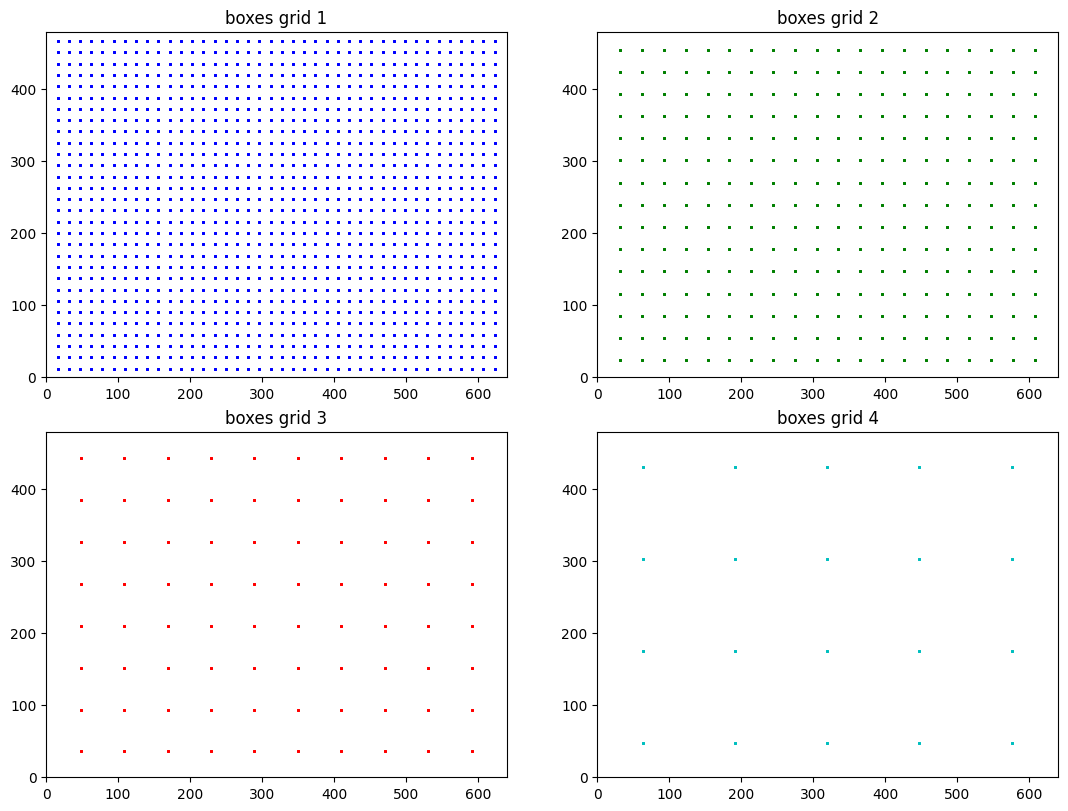

In [14]:
# create default bounding boxes
default_bounding_boxes = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=(0.025, 0.05, 0.075, 0.1),
    additional_square_box=True,
)

# scale default bounding boxes to image shape
default_bounding_boxes.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE)

# create subplots and set figure size
fig_size_width = 11
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))

# set aspect ratio for each subplot
for ax in axes.flat:
    ax.set_aspect('equal')
axes = axes.flatten()

# pick a different color for each grid
colors = list(pltcolors.BASE_COLORS.values())[:len(default_bounding_boxes.feature_maps_shapes)]

# get boxes centroids coordinates for each feature map and plot the boxes centers
i = 0
for boxes_default, color in zip(default_bounding_boxes.get_boxes_coordinates_centroids('feature-maps'), colors):

    # reshape
    boxes_default = boxes_default.reshape((-1, boxes_default.shape[-1]))

    # set plot axes limits and title
    axes[i].set_xlim(0, INPUT_IMAGE_SHAPE[1])
    axes[i].set_ylim(0, INPUT_IMAGE_SHAPE[0])
    axes[i].set_title(f'boxes grid {i +1}')

    # plot centers
    axes[i].scatter(x=boxes_default[:, 0], y=boxes_default[:, 1], color=color, marker='o', s=1)
    
    i+=1

# hide the last axis
if len(axes) > len(default_bounding_boxes.feature_maps_shapes):
    axes[-1].axis('off')

# show the plot
plt.show()

### Default Bounding Boxes

We’ve already seen how SSD places multiple grids of points on the input image.

The next step is to define a set of N default boxes (rectangles), each with a different aspect ratio.

At each grid point, we place this set of N default boxes. This results in multiple grids, each with a set of default boxes at various scales. This variety of default boxes is particularly useful because it allows SSD to detect both small and large objects!

Keep in mind that the SSD framework essentially predicts two things: the offsets needed to adjust the default boxes to fit the actual objects (regression) and the probability that each box contains a specific object class (classification).

Thus, having a well-designed set of default grids and boxes is crucial for achieving good detection results.

Check out the snippet below to see what these default boxes look like!

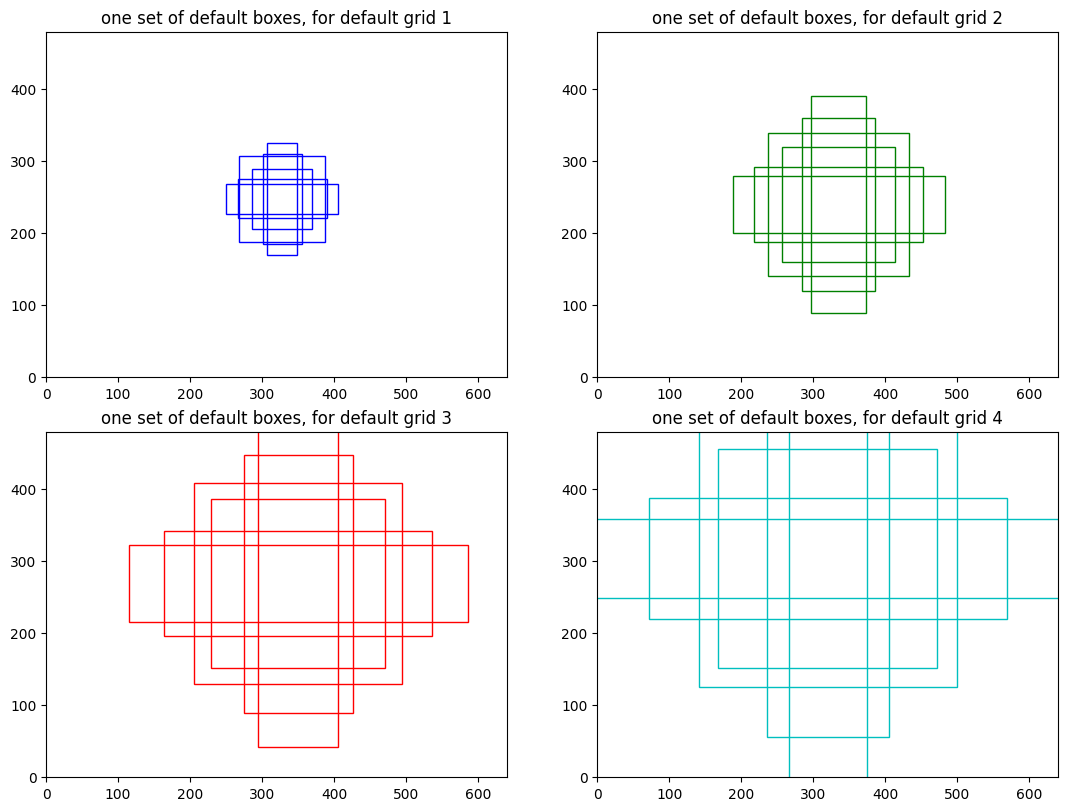

In [17]:
# create subplots and set figure size
fig_size_width = 11
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))

# set aspect ratio for each subplot
for ax in axes.flat:
    ax.set_aspect('equal')
axes = axes.flatten()

# pick a different color for each grid
colors = list(pltcolors.BASE_COLORS.values())[:len(default_bounding_boxes.feature_maps_shapes)]

# get boxes corners coordinates for each feature map and plot the boxes
i = 0
for boxes_default, color in zip(default_bounding_boxes.get_boxes_coordinates_corners('feature-maps'), colors):
   
    # extract boxes around the center of the feature map
    feat_map_center_x = boxes_default.shape[1] // 2
    feat_map_center_y = boxes_default.shape[0] // 2
    boxes_default = boxes_default[feat_map_center_y, feat_map_center_x, :, :]

    # set plot axes limits and title
    axes[i].set_xlim(0, INPUT_IMAGE_SHAPE[1])
    axes[i].set_ylim(0, INPUT_IMAGE_SHAPE[0])
    axes[i].set_title(f'one set of default boxes, for default grid {i + 1}')

    # plot boxes
    for xmin, ymin, xmax, ymax in boxes_default:
        axes[i].add_patch(patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=color, facecolor='none'))
                
    i+=1

# hide the last axis
if len(axes) > len(default_bounding_boxes.feature_maps_shapes):
    axes[-1].axis('off')

# show the plot
plt.show()

## Conclusions

In this notebook, we quickly explored the core ideas behind Single Shot Detector (SSD) for object detection:

1. SSD efficiently handles object detection by performing both classification and localization in a single network pass.

2. SSD uses multiple grids of default boxes with varying aspect ratios and sizes to detect objects of different scales and positions.

3. A network architecture that use SSD will solve two tasks:
   - **Regression**: Predicts offsets to adjust default boxes to match actual object locations.
   - **Classification**: Determines the probability of each box containing a specific object class.

4. Ground truth data usually comes as coordinates of bounding boxes enclosing objects, this must be properly encoded if we want to train a network architeture that use SSD for object detection (more below)

### Ground Truth Data Encoding

For the regression task, the network learns to predict how much to move and scale default boxes to fit detected objects. During training, the network expects ground truth data for regression to be provided as offsets from these default boxes. Therefore, it's crucial to accurately transform and encode the coordinates of ground truth bounding boxes into these offsets to ensure proper network training.
